<a href="https://colab.research.google.com/github/JorgeZarama/TFM-final-models/blob/main/Target_close_Test_de_Stock_Market_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importar Librería

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Attention, Layer, Input, Dropout, concatenate
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.callbacks import EarlyStopping
from sklearn import preprocessing
from tensorflow.keras.optimizers import Adam


Extracción de Datos


In [ ]:
# 1. Extracción de datos
symbol = 'GOOGL'
df = yf.download(symbol, start='2004-08-20', end='2024-07-31', interval='1d')
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
print(df.head())

[*********************100%***********************]  1 of 1 completed

        Date      Open      High       Low     Close  Adj Close     Volume
0 2004-08-20  2.527778  2.729730  2.515015  2.710460   2.703765  456686856
1 2004-08-23  2.771522  2.839840  2.728979  2.737738   2.730975  365122512
2 2004-08-24  2.783784  2.792793  2.591842  2.624374   2.617892  304946748
3 2004-08-25  2.626627  2.702703  2.599600  2.652653   2.646101  183772044
4 2004-08-26  2.626376  2.701451  2.619119  2.700450   2.693780  141897960


Revisar la Data

In [ ]:
display(df.describe(include='all'))
df.info()
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
count,5019,5019.000000,5019.000000,5019.000000,5019.000000,5019.000000,5.019000e+03
mean,2014-08-08 10:01:04.554692096,45.309724,45.784195,44.843776,45.325722,45.215203,1.173464e+08
min,2004-08-20 00:00:00,2.482232,2.546046,2.475976,2.502753,2.496571,9.312000e+06
25%,2009-08-13 12:00:00,13.097973,13.210085,12.943944,13.098223,13.065870,3.104200e+07
50%,2014-08-08 00:00:00,27.608999,27.850000,27.345501,27.584499,27.516365,5.975219e+07
75%,2019-08-03 12:00:00,60.459000,61.028749,60.110748,60.546499,60.396944,1.418720e+08
max,2024-07-30 00:00:00,190.309998,191.750000,189.029999,191.179993,190.926636,1.643023e+09
std,NaN,42.958750,43.431968,42.522119,42.989926,42.888262,1.475160e+08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5019 entries, 0 to 5018
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5019 non-null   datetime64[ns]
 1   Open       5019 non-null   float64       
 2   High       5019 non-null   float64       
 3   Low        5019 non-null   float64       
 4   Close      5019 non-null   float64       
 5   Adj Close  5019 non-null   float64       
 6   Volume     5019 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 274.6 KB


,Date,Open,High,Low,Close,Adj Close,Volume
5014,2024-07-24,173.600006,176.190002,171.820007,172.630005,172.401230,49585200
5015,2024-07-25,172.520004,173.419998,167.190002,167.279999,167.058319,44852000
5016,2024-07-26,167.149994,168.089996,164.059998,167.000000,166.778687,41336900
5017,2024-07-29,168.830002,170.429993,167.990005,169.529999,169.305344,20293800
5018,2024-07-30,170.240005,171.229996,168.440002,170.289993,170.064331,18959700


Gráficamos el valor de la acción (precio de cierre)

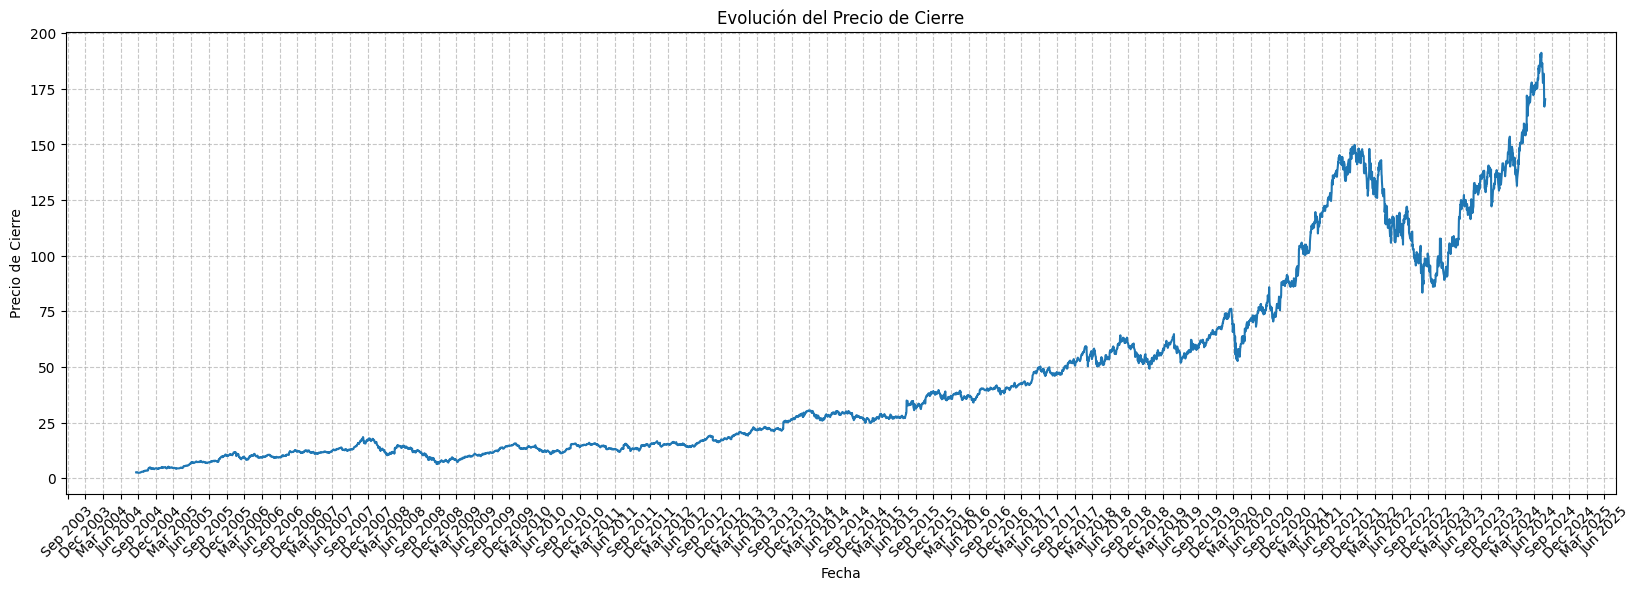

In [ ]:
# Filtrar los datos por el rango de fechas

df_filtrado = df[(df['Date'] >= '2004-08-20') & (df['Date'] <= '2024-07-31')]

# Crear el gráfico de línea
plt.figure(figsize=(20, 6))
sns.lineplot(x='Date', y='Close', data=df_filtrado)

# Personalizar el eje x para mostrar meses y años
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Agregar título y etiquetas a los ejes
plt.title('Evolución del Precio de Cierre')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')

# Agregar una cuadrícula para facilitar la lectura
plt.grid(True, linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

Agregamos una Columna llamada Porcentaje_Cambio_Superior que relaciona el precio de cierre del registro del día con el cierre del día siguiente


Seleccionar las características y la variable objetivo

In [ ]:
close_prices = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices)
def create_lstm_data(data, time_steps=1):
  x, y = [], []
  for i in range(len(data) - time_steps): #removed extra indent
    x.append(data[i:(i + time_steps), 0]) #indented correctly
    y.append(data[i + time_steps, 0]) #indented correctly
  return np.array(x), np.array(y)



## LSTM Model

In [ ]:
time_steps = 100
x_total, y_total = create_lstm_data(close_prices_scaled, time_steps)

dis = int(len(x_total) * 0.95)
display(dis)
x_train, x_test = x_total[:dis], x_total[dis:]
y_train, y_test = y_total[:dis], y_total[dis:]

x = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x, y_train, epochs=50, batch_size=3, validation_data=(x_test, y_test))

4673

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 112s 68ms/step - loss: 0.0017 - val_loss: 5.6584e-04
Epoch 2/50
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 148s 72ms/step - loss: 2.0977e-04 - val_loss: 0.0023
Epoch 3/50
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 144s 73ms/step - loss: 1.2692e-04 - val_loss: 0.0016
Epoch 4/50
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 115s 74ms/step - loss: 1.2505e-04 - val_loss: 2.5042e-04
Epoch 5/50
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 111s 71ms/step - loss: 1.0958e-04 - val_loss: 2.0273e-04
Epoch 6/50
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 142s 71ms/step - loss: 7.2146e-05 - val_loss: 2.9083e-04
Epoch 7/50
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 142s 71ms/step - loss: 6.7078e-05 - val_loss: 3.8522e-04
Epoch 8/50
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 111s 71ms/step - loss: 7.1392e-05 - val_loss: 5.9769e-04
Epoch 9/50
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 141s 71ms/step - loss: 9.0914e-05 - val_loss: 3.0190e-04
Epoch 10/50
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 144s 72ms/step - loss: 6.8544e-05 - val_loss: 2.2016e-04
Epoch 11/50
1558/1558

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.1833e-04
perdidas de test 0.00022661035472992808
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step
Test Loss (MSE): 0.00022661035472992808
Mean Absolute Error (MAE): 1.9966220700643895
Mean Squared Error (MSE): 8.067117509835565
Root Mean Squared Error (RMSE): 2.8402671546591467
R-squared (R²): 0.9757775797975636


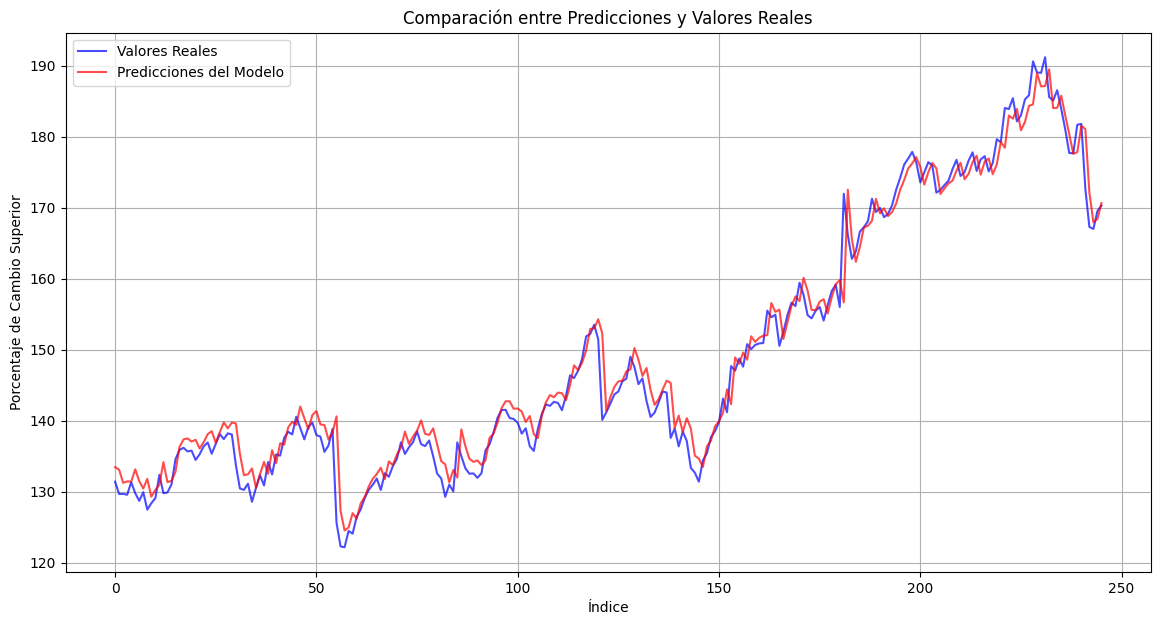

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(x_test, y_test)
print("perdidas de test", test_loss)
# Predicción
predictions = model.predict(x_test)

# Desescalar las predicciones
predictions = scaler.inverse_transform(predictions)

#Reshape y_test to be a 2D array before inverse_transform
y_test = y_test.reshape(-1, 1)

y_test = scaler.inverse_transform(y_test)

# Calcular métricas adicionales
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

# Mostrar las métricas
print(f"Test Loss (MSE): {test_loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

# Crear el gráfico
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Valores Reales', color='blue', alpha=0.7)
plt.plot(predictions, label='Predicciones del Modelo', color='red', alpha=0.7)
plt.xlabel('Índice')
plt.ylabel('Porcentaje de Cambio Superior')
plt.title('Comparación entre Predicciones y Valores Reales')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
end_date = '2024-07-30'
future_dates = pd.date_range(start=end_date, periods=5)
display(future_dates)
last_prices = close_prices[-time_steps:]
last_prices_scaled = scaler.transform(last_prices.reshape(-1, 1))
x_pred = np.array([last_prices_scaled[-time_steps:, 0]])
x_pred = np.reshape(x_pred, (x_pred.shape[0], x_pred.shape[1], 1))
predicted_prices_scaled = model.predict(x_pred)
display(predicted_prices_scaled)
predicted_prices = scaler.inverse_transform(predicted_prices_scaled)

DatetimeIndex(['2024-07-30', '2024-07-31', '2024-08-01', '2024-08-02',
               '2024-08-03'],
              dtype='datetime64[ns]', freq='D')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


array([[0.87651044]], dtype=float32)